# Rechecking ampselfcal after Feb reruns


In [1]:
noisedir = "/orange/adamginsburg/ALMA_IMF/reduction/reduction/noise_estimation_regions/"

In [2]:
from spectral_cube import SpectralCube

In [3]:
import warnings
import spectral_cube
warnings.simplefilter('ignore', spectral_cube.utils.BeamWarning)
warnings.simplefilter('ignore', spectral_cube.utils.StokesWarning)
warnings.simplefilter('ignore', spectral_cube.utils.PossiblySlowWarning)
warnings.simplefilter('ignore', spectral_cube.utils.WCSWarning)

In [33]:
%matplotlib inline
import numpy as np
from astropy import units as u
import pylab as pl
pl.style.use('default')
pl.rcParams['figure.figsize'] = (16,5)
pl.rcParams['image.origin'] = 'lower'
import sys
import glob
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/reduction/')
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube
import spectral_cube
from astropy.visualization import simple_norm
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import mad_std


In [91]:
def compare_withamp_withoutamp(withamp, withoutamp, noisereg, zoom=slice(None), max_percent=99.9, min_percent=None, stretch1='linear',
                               stretch2='linear', nsigma_linear_min=5, nsigma_linear_max=5,
                               tick_fontsize=16, fontsize=20, pad2="15%",
                               noise_threshold=3, shrink=0.85, cmap1='gray_r', cmap2='inferno', diffnorm=None, scalebar=5*u.arcsec):
    try:
        noamp = SpectralCube.read(withoutamp).to(u.mJy)
        withamp = SpectralCube.read(withamp).to(u.mJy)
    except:
        noamp = SpectralCube.read(withoutamp).to(u.mJy/u.beam)
        withamp = SpectralCube.read(withamp).to(u.mJy/u.beam)

    
    reg = regions.read_ds9(noisereg)
    
    noise_noamp = noamp.subcube_from_regions(reg).mad_std()
    noise_withamp = withamp.subcube_from_regions(reg).mad_std()
    print(f"Noise w/o: {noise_noamp:0.6g}")
    print(f"Noise with: {noise_withamp:0.6g}")
    print(f"Fractional difference: {(noise_noamp-noise_withamp)/noise_noamp}")
    print()
    
    noamp_dr = noamp.max()/noise_noamp
    withamp_dr = withamp.max()/noise_withamp
    print(f"Dynamic range without: {noamp_dr}")
    print(f"Dynamic range with: {withamp_dr}")
    print(f"Fractional difference (with-no)/no: {(withamp_dr-noamp_dr)/noamp_dr}")
    print()
    
    mask = (noamp > noise_noamp*noise_threshold) & (withamp > noise_withamp*noise_threshold)
    ratio = (noamp/withamp).with_mask(mask)
    print(f"Flux ratio (no amp / with amp) 25%: {ratio.percentile(25)}  50%: {ratio.median()}  75%: {ratio.percentile(75)}")
    sum_noamp = noamp.with_mask(mask).sum()
    sum_withamp = withamp.with_mask(mask).sum()
    print(f"Flux sum ratio: with/without={sum_withamp/sum_noamp}, fractional (with-without)/without={(sum_withamp-sum_noamp)/sum_noamp}")
    print()
    
    fig,((ax1,ax2,ax3)) = pl.subplots(1,3, figsize=(16,5))
    
    #norm1 = simple_norm(noamp[0].value[zoom], max_percent=max_percent, min_percent=min_percent, stretch=stretch1)
    #im1 = ax1.imshow(noamp[0].value[zoom], norm=norm1, cmap=cmap1, origin='lower', interpolation='none')
    #norm2 = simple_norm(noamp[0].value[zoom], max_percent=max_percent, min_value=min_percent, stretch=stretch1)
    #im2 = ax1.imshow(noamp[0].value[zoom], norm=norm2, cmap=cmap1, origin='lower', interpolation='none')
    
    img = noamp[0].value[zoom]
    mad = mad_std(img, ignore_nan=True)

    norm1 = simple_norm(img, stretch=stretch1, min_cut=-nsigma_linear_min*mad, max_cut=nsigma_linear_max*mad,)

    overview_cmap = pl.cm.get_cmap(cmap1)
    overview_cmap.set_bad('white')

    im1 = ax1.imshow(img, cmap=overview_cmap, norm=norm1, origin='lower', interpolation='none')

    cm = pl.cm.get_cmap(cmap2)
    cm.set_under((0,0,0,0))

    vmin = norm1.vmax*0.99
    norm2 = simple_norm(img, min_cut=vmin, stretch=stretch2, max_percent=max_percent)
    norm2.vmin = vmin

    im2 = ax1.imshow(img, cmap=cm, norm=norm2, vmin=norm2.vmin, origin='lower', interpolation='none')

    
    
    blc = np.array(noamp[0].value[zoom].shape)*0.1
    pixscale = np.abs(noamp[0].wcs.pixel_scale_matrix[0,0] * u.deg)
    scalebarlen = scalebar / pixscale
    ax1.plot([blc[1], blc[1]+scalebarlen], [blc[0], blc[0]], 'w')
    ax1.text(blc[1] + scalebarlen/2, blc[0] * 1.12, f'{scalebar.to(u.arcsec).value:0.1f}"',
             color='w', horizontalalignment='center', verticalalignment='bottom')
    
    #divider = make_axes_locatable(ax1)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb = fig.colorbar(mappable=im, ax=ax1, cax=cax)
    #cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax1.set_title("No amp selfcal")
    im1 = ax2.imshow(withamp[0].value[zoom], norm=norm1, cmap=cmap1, origin='lower', interpolation='none')
    im2 = ax2.imshow(withamp[0].value[zoom], norm=norm2, cmap=cmap2, origin='lower', interpolation='none')

    #divider = make_axes_locatable(ax2)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb = fig.colorbar(mappable=im, ax=ax2, cax=cax)
    #cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax2.set_title("With amp selfcal")

    
    diff = (noamp[0].value-withamp[0].value)[zoom]
    #im = ax3.imshow(diff, norm=simple_norm(diff, min_percent=1, max_percent=99, stretch='asinh'), cmap=cmap)
    #im = ax3.imshow(diff, cmap=cmap, norm=diffnorm, origin='lower', interpolation='none')
    im = ax3.imshow(diff, cmap=cmap1, norm=norm1, origin='lower', interpolation='none')
    im = ax3.imshow(diff, cmap=cmap2, norm=norm2, origin='lower', interpolation='none')
    
    #divider = make_axes_locatable(ax3)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb = fig.colorbar(mappable=im, ax=ax3, cax=cax)
    #cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax3.set_title("No amp - With amp")
    
    for ax in (ax1,ax2,ax3):
        ax.set_xticks([])
        ax.set_yticks([])
    #pl.subplots_adjust(hspace=0.05, wspace=0.05)
    pl.tight_layout()

    
    # HACKARONI AND CHEESE
    # the individual images get resized (INCORRECTLY!!!) when adding a colorbar
    divider = make_axes_locatable(ax1)
    cax_X1 = divider.append_axes("right", size="3%", pad="2%", axes_class=pl.matplotlib.axes.Axes)
    cax_X2 = divider.append_axes("right", size="3%", pad=pad2, axes_class=pl.matplotlib.axes.Axes)
    divider = make_axes_locatable(ax2)
    cax_Y1 = divider.append_axes("right", size="3%", pad="2%", axes_class=pl.matplotlib.axes.Axes)
    cax_Y2 = divider.append_axes("right", size="3%", pad=pad2, axes_class=pl.matplotlib.axes.Axes)
    #cb_ = pl.colorbar(mappable=im2, cax=cax_Y)

    
    divider = make_axes_locatable(ax3)

    cax1 = divider.append_axes("right", size="3%", pad="2%", axes_class=pl.matplotlib.axes.Axes)
    cax2 = divider.append_axes("right", size="3%", pad=pad2, axes_class=pl.matplotlib.axes.Axes)

    cb2 = pl.colorbar(mappable=im2, cax=cax2)
    cb1 = pl.colorbar(mappable=im1, cax=cax1)
    cb1.ax.tick_params(labelsize=tick_fontsize)
    cb2.ax.tick_params(labelsize=tick_fontsize)
    cb2.set_label(r'S$_\nu$ [mJy beam$^{-1}$]', fontsize=fontsize)
    
    for ax in (cax_X1, cax_X2, cax_Y1, cax_Y2):
        ax.remove()
        #fig.axes.remove(ax)
    pl.tight_layout()
    
    return noamp, withamp, ratio

In [18]:
reldir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/"

In [19]:
rstimresdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults"
decdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/December2020Release/"

In [20]:
imdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/"

In [21]:
ls -d /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal*image.tt0

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0/


Noise w/o: 0.0776309 mJy / beam
Noise with: 0.0594815 mJy / beam
Fractional difference: 0.23379024162264497

Dynamic range without: 3583.482183814295
Dynamic range with: 4837.2115680493025
Fractional difference (with-no)/no: 0.34986343448219004

Flux ratio (no amp / with amp) 25%: 0.8936837723979895  50%: 0.9617680852875876  75%: 1.0760869547032632
Flux sum ratio: with/without=1.0504275942302668, fractional (with-without)/without=0.05042759423026676



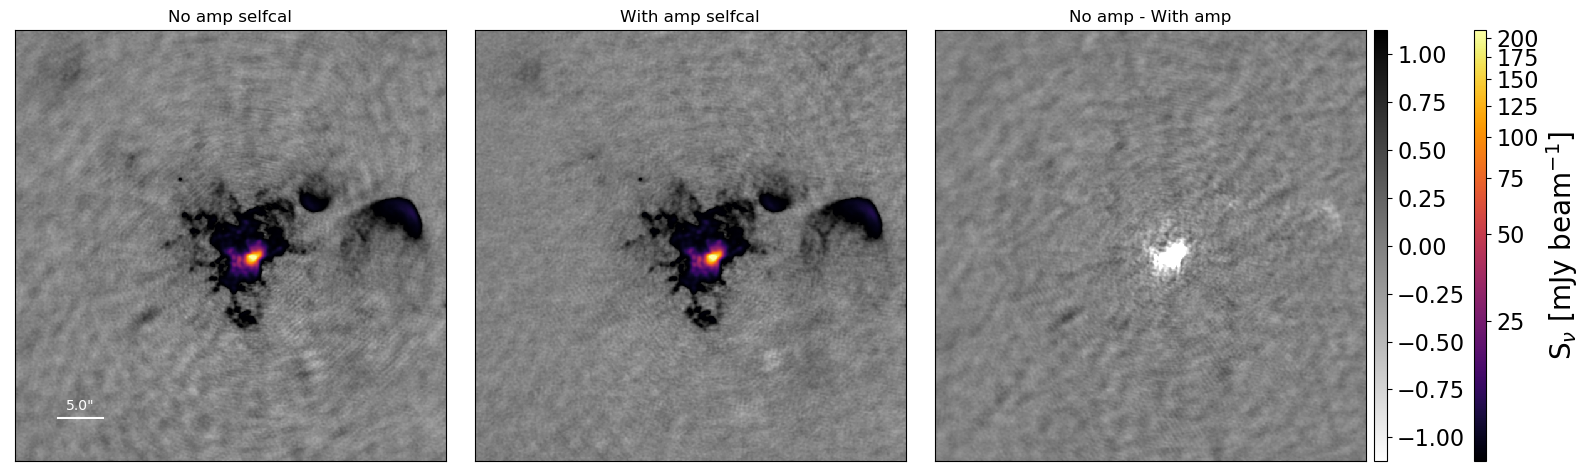

In [94]:
with pl.style.context('default'):
    _=compare_withamp_withoutamp(withamp=f'{reldir}/G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits',
                               withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                               noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                               #  cmap='viridis',
                               zoom=(slice(1000,-1000), slice(1000,-1000)),
                               max_percent=99.99,
                               stretch2='asinh',
                                 nsigma_linear_min=10,
                                 nsigma_linear_max=10,
                                 pad2="20%",
                               min_percent=0)
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G010.62_B3_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')

Noise w/o: 0.0844796 mJy / beam
Noise with: 0.0823351 mJy / beam
Fractional difference: 0.02538500599880205

Dynamic range without: 4546.702880772178
Dynamic range with: 4645.702729696043
Fractional difference (with-no)/no: 0.021773986891145108

Flux ratio (no amp / with amp) 25%: 0.97564664823014  50%: 1.0257761717449088  75%: 1.1295008429048226
Flux sum ratio: with/without=0.9801363649489238, fractional (with-without)/without=-0.019863635051076262



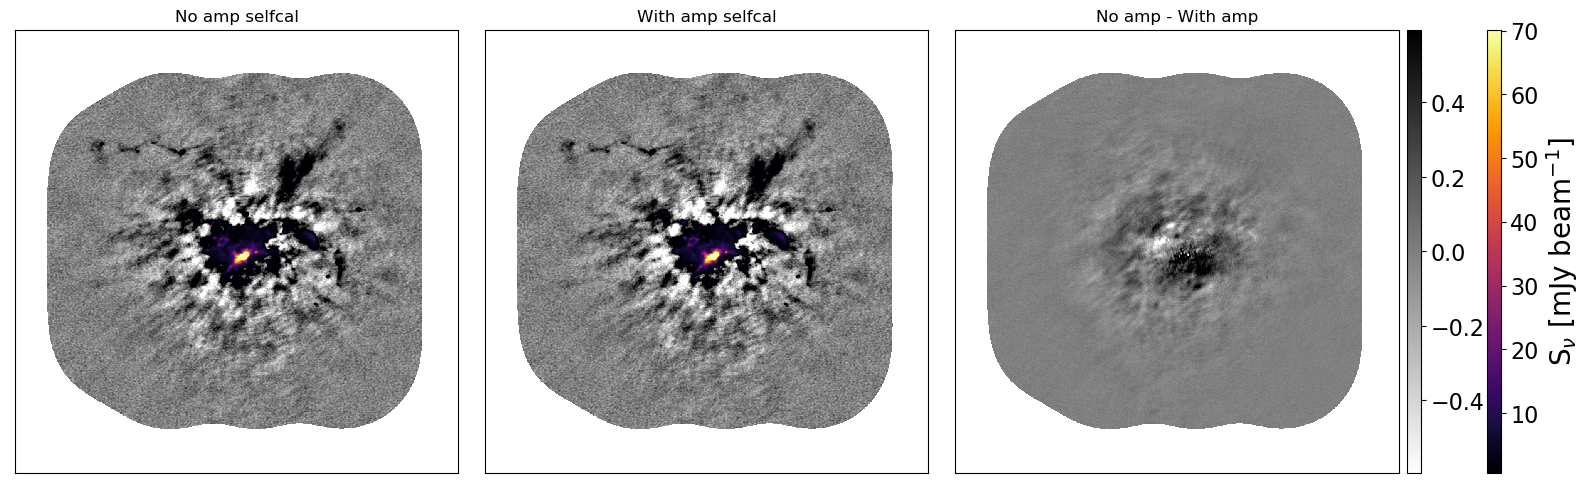

In [86]:
_=compare_withamp_withoutamp(withoutamp=f'{reldir}/G010.62/B6/cleanest/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits',
                             withamp=f'{imdir}/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal4.image.tt0.fits',
                             noisereg=f"{noisedir}/G010.62_B6_noise_sampling.reg",
                             max_percent=99.95,
                             min_percent=1,
                             #stretch='asinh'                 
                            )

Noise w/o: 0.0852354 mJy
Noise with: 0.0834627 mJy
Fractional difference: 0.020798679666961847

Dynamic range without: 4506.383086834392
Dynamic range with: 4606.31547790649
Fractional difference (with-no)/no: 0.022175742529314667

Flux ratio (no amp / with amp) 25%: 0.9719708561897278  50%: 1.021201729774475  75%: 1.117600440979004
Flux sum ratio: with/without=0.9861669540405273, fractional (with-without)/without=-0.01383307483047247



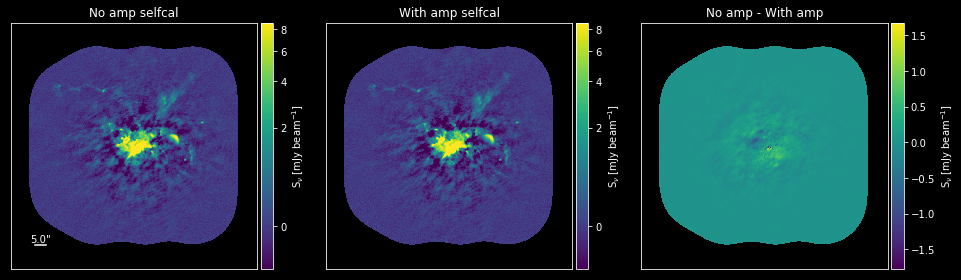

In [84]:
_=compare_withamp_withoutamp(withoutamp=f'{reldir}/G010.62/B6/cleanest/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits',
                             withamp=f'{imdir}/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal4.image.tt0.fits',
                             noisereg=f"{noisedir}/G010.62_B6_noise_sampling.reg",
                             max_percent=99.5,
                             min_percent=1,
                             stretch='asinh'
                             
                            )

Noise w/o: 0.0946582 mJy
Noise with: 0.0594815 mJy
Fractional difference: 0.3716174591951395

Dynamic range without: 3039.42686225952
Dynamic range with: 4837.211628750419
Fractional difference (with-no)/no: 0.5914880824453922

Flux ratio (no amp / with amp) 25%: 0.9424992203712463  50%: 1.0086246728897095  75%: 1.1714239120483398
Flux sum ratio: with/without=0.9988921880722046, fractional (with-without)/without=-0.0011077985400334



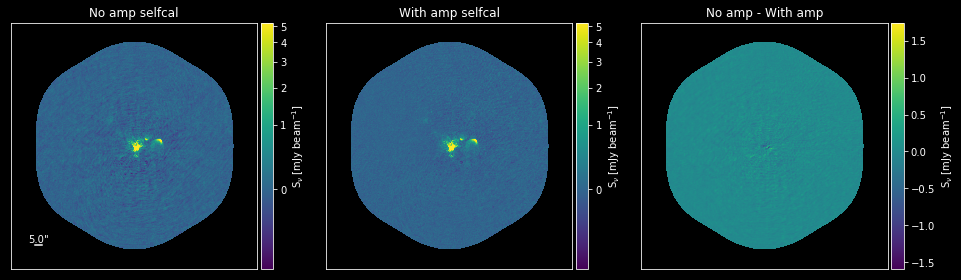

In [85]:
_=compare_withamp_withoutamp(withamp=f'{reldir}/G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits',
                           withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                           noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                          )

_=compare_withamp_withoutamp(withamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal8.image.tt0.fits',
                             withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                             noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                             zoom=(slice(1000,-1000), slice(1000,-1000)),
                             max_percent=99.9,
                             stretch='log',
                             min_percent=1)

In [87]:
glob.glob(f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal*image.tt0")

['/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0']

Noise w/o: 0.139147 mJy
Noise with: 0.135075 mJy
Fractional difference: 0.02926928209488287

Dynamic range without: 1580.1675148371096
Dynamic range with: 1598.1406157353733
Fractional difference (with-no)/no: 0.011374174402083239

Flux ratio (no amp / with amp) 25%: 1.0027506351470947  50%: 1.027970552444458  75%: 1.0777089595794678
Flux sum ratio: with/without=0.9833692312240601, fractional (with-without)/without=-0.016630778089165688



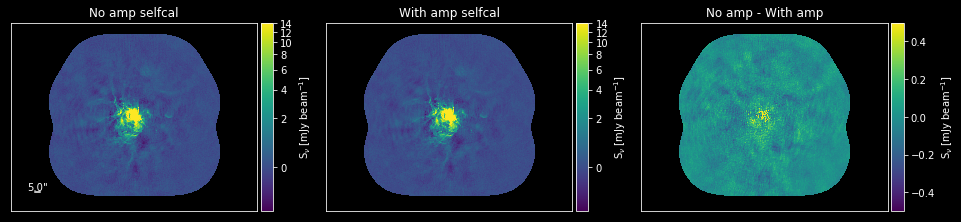

In [88]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                               withoutamp=f'{imdir}/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                           noisereg=f"{noisedir}/G333.60_B3_noise_sampling.reg",
                             max_percent=99.5,
                             diffnorm=simple_norm(data=[0,1], min_cut=-0.5, max_cut=0.5)
                          )

Noise w/o: 0.0801445 mJy / beam
Noise with: 0.0897109 mJy / beam
Fractional difference: -0.1193654906339733

Dynamic range without: 2662.476553820725
Dynamic range with: 2406.2625354716415
Fractional difference (with-no)/no: -0.09623146464197378

Flux ratio (no amp / with amp) 25%: 0.9154221050087048  50%: 1.0298999539287728  75%: 1.1754689797810771
Flux sum ratio: with/without=0.9971307738335066, fractional (with-without)/without=-0.002869226166493429



(SpectralCube with shape=(1, 3000, 3920) and unit=mJy / beam:
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz,
 SpectralCube with shape=(1, 3000, 3920) and unit=mJy / beam:
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz,
 SpectralCube with shape=(1, 3000, 3920):
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz)

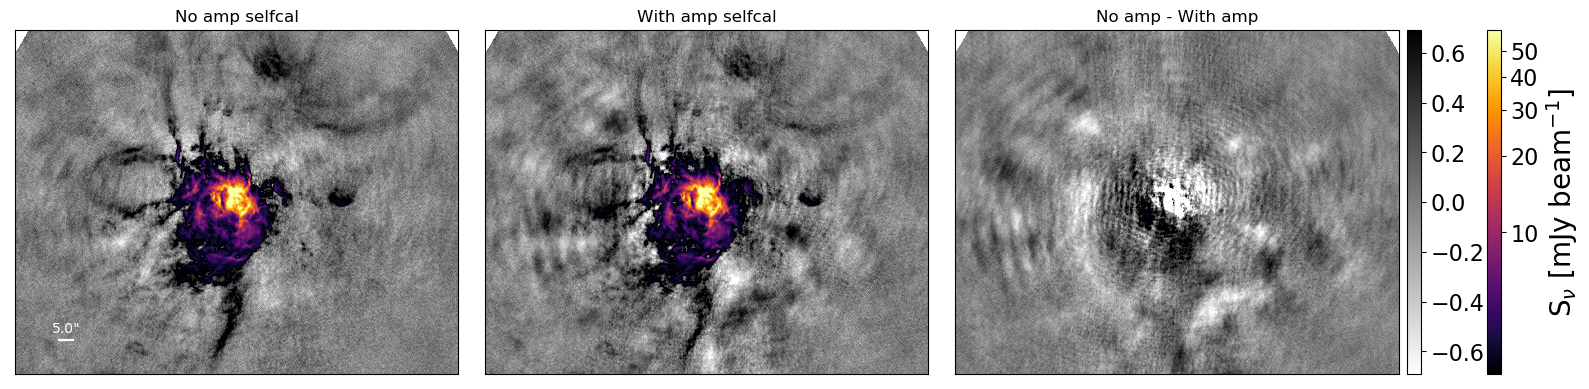

In [102]:
compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withoutamp=f'{imdir}/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                           noisereg=f"{noisedir}/G333.60_B3_noise_sampling.reg",
                           zoom=(slice(600,-600), slice(800,-800)),
                           max_percent=99.9,
                           stretch2='asinh',
                           diffnorm=simple_norm(data=[0,1], min_cut=-0.5, max_cut=0.5),                     
                           min_percent=1)

Noise w/o: 0.118855 mJy / beam
Noise with: 0.114712 mJy / beam
Fractional difference: 0.03485609724676288

Dynamic range without: 2056.9868101224424
Dynamic range with: 2126.474791289655
Fractional difference (with-no)/no: 0.033781442265580865

Flux ratio (no amp / with amp) 25%: 0.981813150348009  50%: 1.0349766481477822  75%: 1.170971226319516
Flux sum ratio: with/without=0.9791410747761752, fractional (with-without)/without=-0.02085892522382479



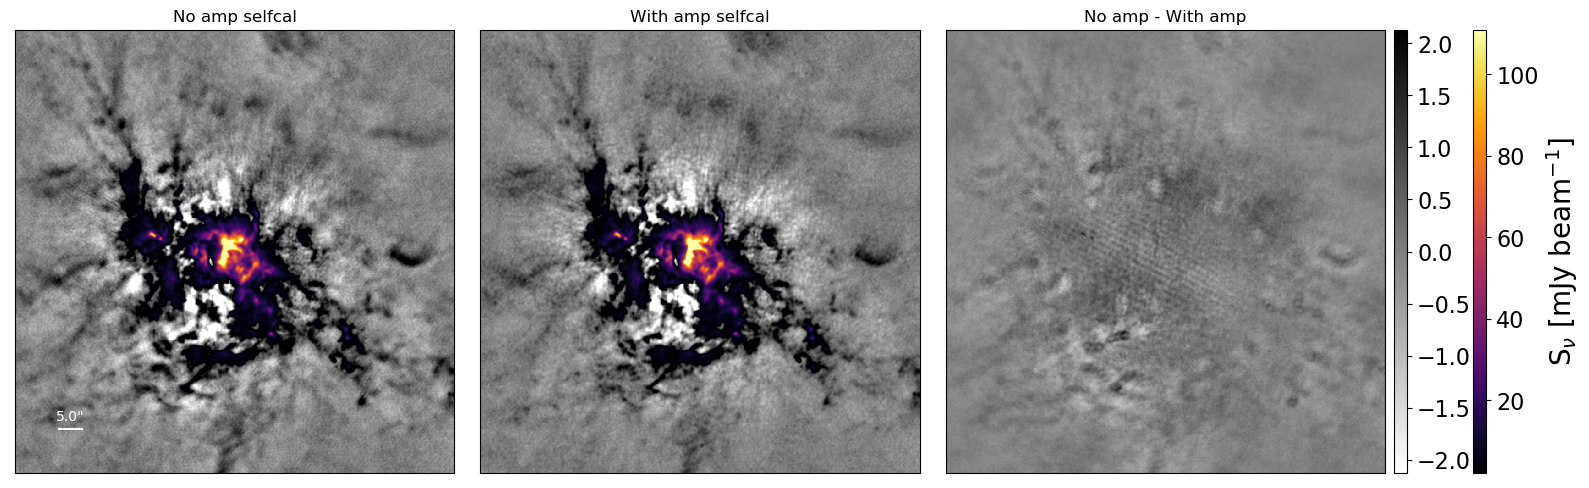

In [99]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B6/cleanest/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                             withoutamp=f'{imdir}/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                             noisereg=f"{noisedir}/G333.60_B6_noise_sampling.reg",
                             zoom=(slice(300,-300), slice(600,-600)),                             
                            )

Noise w/o: 0.118855 mJy / beam
Noise with: 0.114712 mJy / beam
Fractional difference: 0.03485609724676288

Dynamic range without: 2056.9868101224424
Dynamic range with: 2126.474791289655
Fractional difference (with-no)/no: 0.033781442265580865

Flux ratio (no amp / with amp) 25%: 0.981813150348009  50%: 1.0349766481477822  75%: 1.170971226319516
Flux sum ratio: with/without=0.9791410747761752, fractional (with-without)/without=-0.02085892522382479



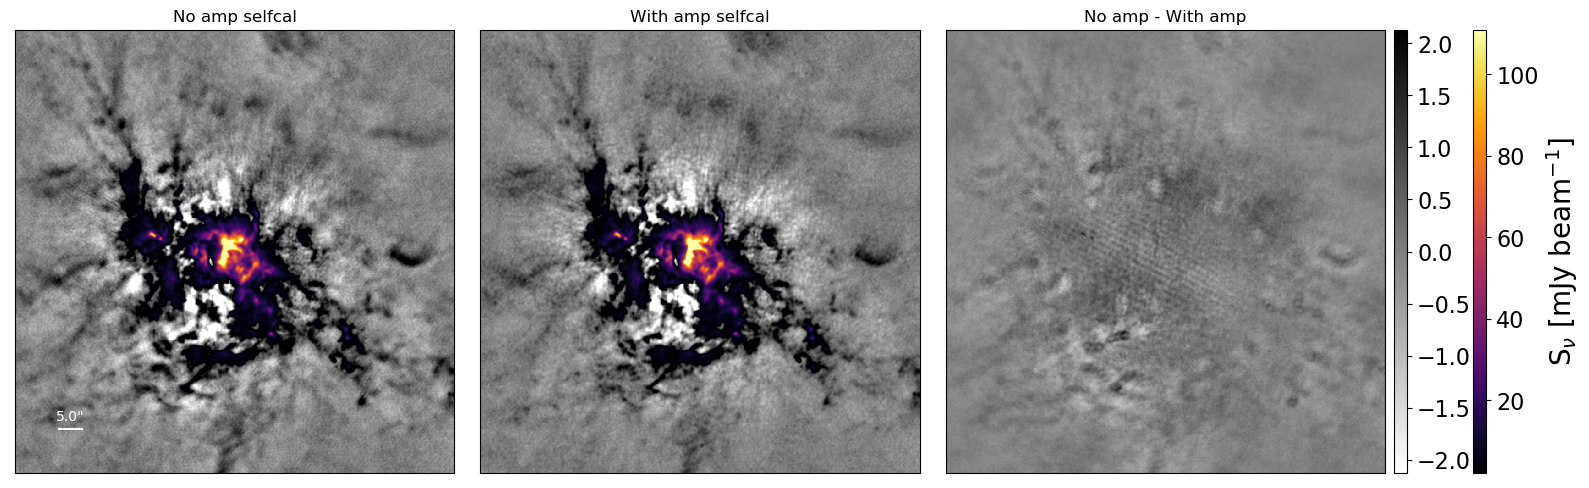

In [96]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B6/cleanest/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                             withoutamp=f'{imdir}/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                             noisereg=f"{noisedir}/G333.60_B6_noise_sampling.reg",
                             zoom=(slice(300,-300), slice(600,-600)),
                             max_percent=99.9,
                            )

Noise w/o: 0.187392 mJy
Noise with: 0.175808 mJy
Fractional difference: 0.06181722729942512

Dynamic range without: 933.1264921259852
Dynamic range with: 988.4752824043932
Fractional difference (with-no)/no: 0.059315420519574176

Flux ratio (no amp / with amp) 25%: 0.9829449951648712  50%: 1.0062874555587769  75%: 1.030359536409378
Flux sum ratio: with/without=0.9934602379798889, fractional (with-without)/without=-0.006539779249578714



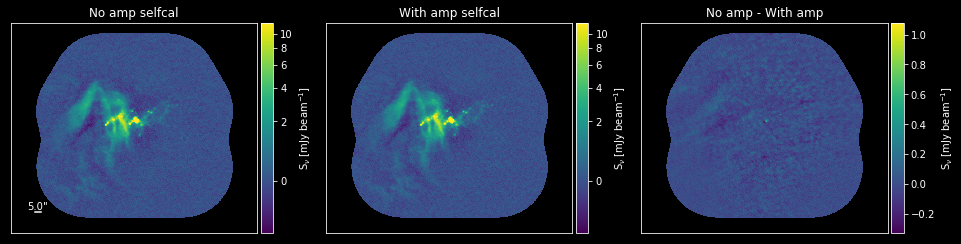

In [92]:
_=compare_withamp_withoutamp(withoutamp=f"{reldir}/G353.41/B3/cleanest/G353.41_B3_uid___A001_X1296_X1d5_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withamp=f"{decdir}/G353.41/B3/cleanest/G353.41_B3_uid___A001_X1296_X1d5_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           noisereg=f"{noisedir}/G353.41_B3_noise_sampling.reg",
                           #zoom=(slice(300,-300), slice(600,-600)),
                           #max_percent=99.9,
                           #stretch='log',
                           #min_percent=0
                          )

Noise w/o: 0.418046 mJy
Noise with: 0.40756 mJy
Fractional difference: 0.02508352472765285

Dynamic range without: 268.57680302256244
Dynamic range with: 268.40724128646946
Fractional difference (with-no)/no: -0.0006313342559176373

Flux ratio (no amp / with amp) 25%: 0.9928571283817291  50%: 1.0246727466583252  75%: 1.0493897795677185
Flux sum ratio: with/without=0.9768317341804504, fractional (with-without)/without=-0.023168247193098068



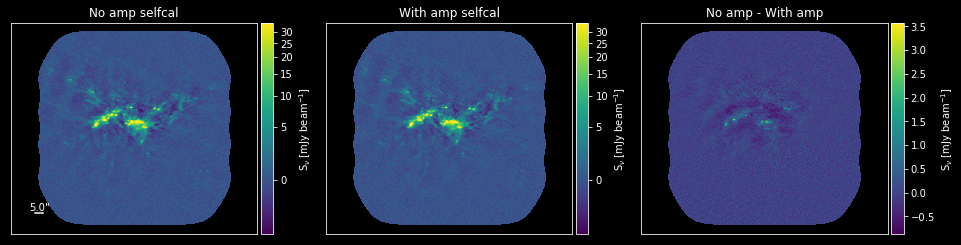

In [93]:
_=compare_withamp_withoutamp(withamp=f"{decdir}/G353.41/B6/cleanest/G353.41_B6_uid___A001_X1296_X1c9_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withoutamp=f"{reldir}/G353.41/B6/cleanest/G353.41_B6_uid___A001_X1296_X1c9_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           noisereg=f"{noisedir}/G353.41_B6_noise_sampling.reg",
                           #zoom=(slice(300,-300), slice(600,-600)),
                           #max_percent=99.9,
                           #stretch='log',
                           #min_percent=0
                          )

Noise w/o: 0.0317187 mJy
Noise with: 0.036066 mJy
Fractional difference: -0.13705640944649072

Dynamic range without: 190.48169341896522
Dynamic range with: 203.4886621053013
Fractional difference (with-no)/no: 0.06828461283010122

Flux ratio (no amp / with amp) 25%: 0.8016194701194763  50%: 0.8419809937477112  75%: 0.8994202166795731
Flux sum ratio: with/without=1.2134987115859985, fractional (with-without)/without=0.21349866688251495



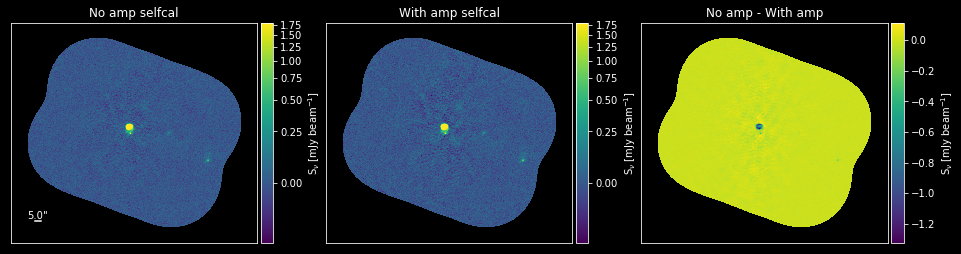

In [94]:
noamp, withamp, ratio = compare_withamp_withoutamp(
    withamp=f"{decdir}/W43-MM3/B3/cleanest/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
    withoutamp=f"{reldir}/W43-MM3/B3/cleanest/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
    noisereg=f"{noisedir}/W43-MM3_B3_noise_sampling.reg",
    #zoom=(slice(300,-300), slice(300,-300)),
    #max_percent=99.9,
    #stretch='log',
    #min_percent=1,
)

Noise w/o: 0.307947 mJy / beam
Noise with: 0.236541 mJy / beam
Fractional difference: 0.23187843338903436

Dynamic range without: 2763.422395460352
Dynamic range with: 3498.639305821152
Fractional difference (with-no)/no: 0.26605303321294166

Flux ratio (no amp / with amp) 25%: 1.0411590350765771  50%: 1.064201901318472  75%: 1.1208704106389256
Flux sum ratio: with/without=0.9461001634379081, fractional (with-without)/without=-0.053899836562091824



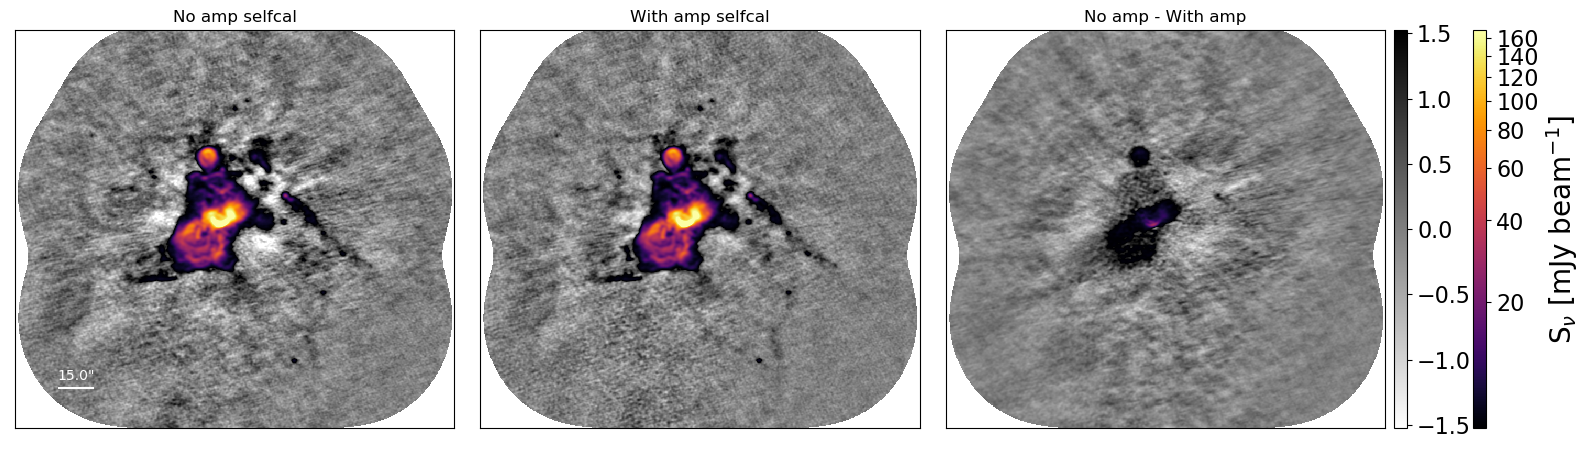

In [85]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        withoutamp=f"{rstimresdir}/G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal6.image.tt0.fits",
        withamp=f"{reldir}/G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.fits",
        noisereg=f"{noisedir}/G012.80_B3_noise_sampling.reg",
        zoom=(slice(100,-100), slice(60,-60)),
        #max_percent=99.9,
        scalebar=15*u.arcsec,
        stretch2='asinh',
        #min_percent=1,
        diffnorm=simple_norm([0,1], min_cut=-1.5, max_cut=1.5)
    )
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G012.80_B3_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    

Noise w/o: 0.335155 mJy / beam
Noise with: 0.324017 mJy / beam
Fractional difference: 0.033233761282119835

Dynamic range without: 1209.7404900378963
Dynamic range with: 1248.6478438681015
Fractional difference (with-no)/no: 0.032161735637191435

Flux ratio (no amp / with amp) 25%: 0.8856442998321795  50%: 0.9588011855233456  75%: 1.005347805499658
Flux sum ratio: with/without=1.0242833089334855, fractional (with-without)/without=0.02428330893348548



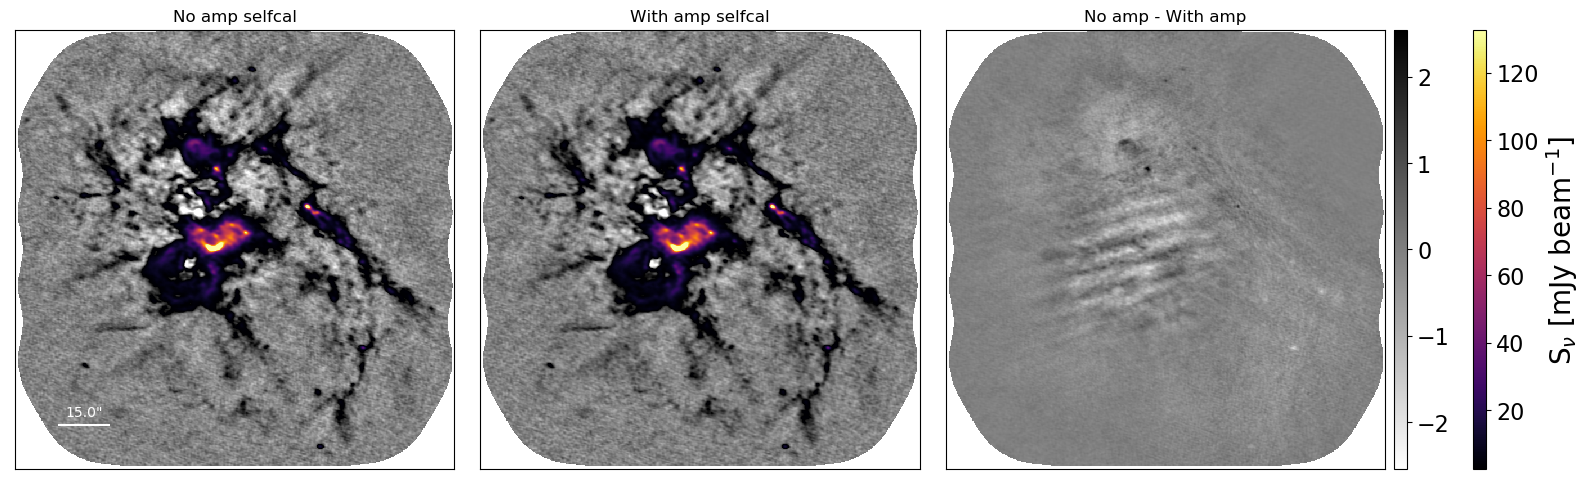

In [83]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        #withamp=   f"{decdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
        #withoutamp=f"{reldir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
        withamp=f"{rstimresdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
        withoutamp=f"{rstimresdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5.image.tt0.fits",
        noisereg=  f"{noisedir}/G012.80_B6_noise_sampling.reg",
        zoom=(slice(50,-50), slice(50,-50)),
        max_percent=99.95,
        scalebar=15*u.arcsec,
        #stretch='log',
        #min_percent=1,
    )
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G012.80_B6_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    

Noise w/o: 0.112772 mJy / beam
Noise with: 0.0946762 mJy / beam
Fractional difference: 0.16046117800129064

Dynamic range without: 7969.600493333613
Dynamic range with: 9345.582839195644
Fractional difference (with-no)/no: 0.1726538672814288

Flux ratio (no amp / with amp) 25%: 0.9679519366779584  50%: 1.024081997660509  75%: 1.1048911218302484
Flux sum ratio: with/without=0.9823018237167754, fractional (with-without)/without=-0.017698176283224554



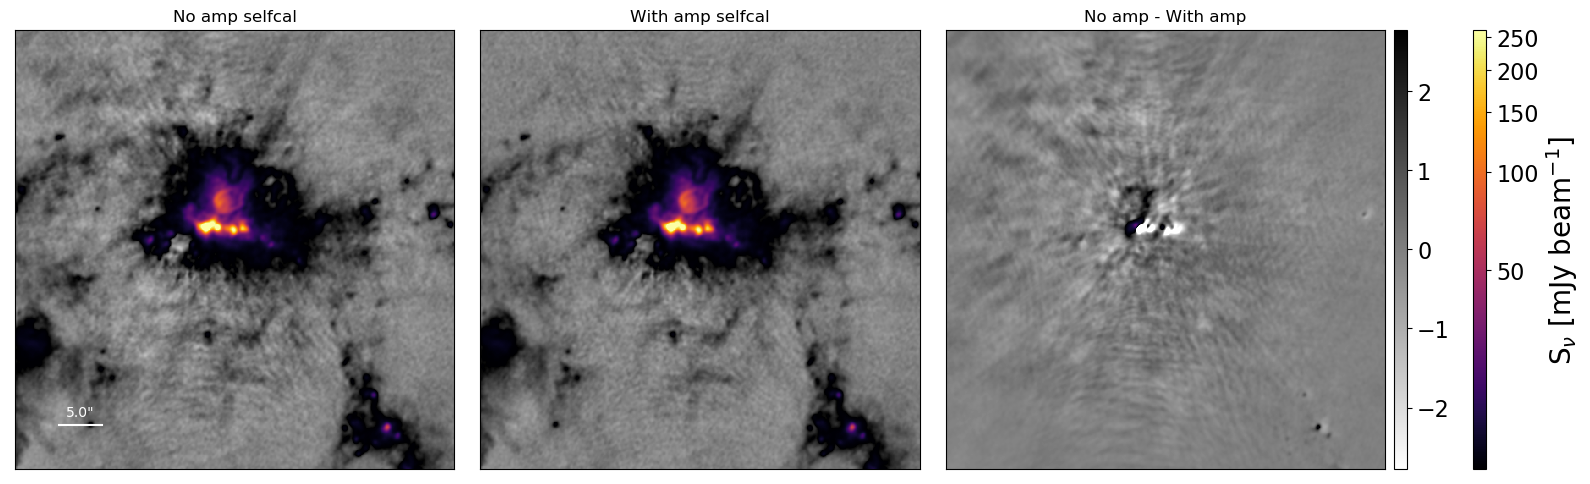

In [82]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        withamp=        f"{reldir}/W51-IRS2/B6/cleanest/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits",
        withoutamp=f"{rstimresdir}/W51-IRS2/B6/cleanest/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal8.image.tt0.fits",
        noisereg=     f"{noisedir}/W51-IRS2_B6_noise_sampling.reg",
        zoom=(slice(300,-300), slice(300,-300)),
        max_percent=99.95,
        stretch2='asinh',
        min_percent=2,
        diffnorm=simple_norm([0,1], min_cut=-2, max_cut=2)
    )
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/W51-IRS2_B6_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    